## Lightning 

* Damspster fusion accuracy is always low than the evidential accuracy. 
* Multiframe accuracy is less than single frame accuracy .
* The uncertainty reduces after fusion but accuracy reduces .
    - This is very bad. 
* After taining to accuracy above 80% the fusion is giving better accuracy
* For 93% there is not difference with accuracy
* for desctrucitve fusion the order maters . 
   - This is important for our usecase where our data gets better by time.

### ToDo
1. Train with the fused network
2. Average, sum comprison
3. ~~Average alpha 
    - Max alpha each prediction and avverage of it 
4. ~~Average uncertainty.~~
5. Qualitative analysis . Plot 5 wrong images and its uncertainty also for fusion
6. Entropy 



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torchmetrics
import torchvision
from IPython.core.display import display
from kornia import image_to_tensor, tensor_to_image
from kornia.augmentation import ColorJitter, RandomChannelShuffle, RandomHorizontalFlip, RandomThinPlateSpline
from kornia.augmentation import RandomVerticalFlip
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import StochasticWeightAveraging
from pytorch_lightning.loggers import CSVLogger

from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from sklearn.metrics import ConfusionMatrixDisplay

import uncertain_fusion
import evidence_loss
sn.set()

/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352660876/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class DataAugmentation(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self, apply_color_jitter: bool = False) -> None:
        super().__init__()
        self._apply_color_jitter = apply_color_jitter

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.50),
            RandomChannelShuffle(p=0.50),
            RandomThinPlateSpline(p=0.50),
        )

        self.jitter = ColorJitter(0.5, 0.5, 0.5, 0.5)

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        x_out = self.transforms(x)  # BxCxHxW
        if self._apply_color_jitter:
            x_out = self.jitter(x_out)
        return x_out

In [4]:
class Preprocess(nn.Module):
    """Module to perform pre-process using Kornia on torch tensors."""

    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x) -> Tensor:
        x_tmp: np.ndarray = np.array(x)  # HxWxC
        x_out: Tensor = image_to_tensor(x_tmp, keepdim=True)  # CxHxW
        return x_out.float() / 255.0

## Single frame model and training

In [73]:
class CoolSystem(LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        
        self.n_classes = 10
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        

    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        y = F.one_hot(y, self.n_classes)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = evidence_loss.edl_mse_loss(y_hat, y, self.current_epoch, self.n_classes, 5)
   
        #return F.cross_entropy(y_hat, y)
        return loss

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.train_cm(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        self.log("valid_loss", loss, prog_bar=False)
        self.log("valid_acc", self.val_accuracy, prog_bar=True)
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.valid_cm(y_hat, y)
        
    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(8,8))
        #plt.imshow(self.valid_cm.compute().cpu().numpy())
        disp = ConfusionMatrixDisplay(self.valid_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, self.trainer.max_epochs, 0)
        return [optimizer], [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=int(16/2))
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=2, shuffle=False, num_workers=int(16/2))
        return loader

In [50]:
# init model
model = CoolSystem()

In [45]:
batch = next(iter(model.val_dataloader()))

Files already downloaded and verified


In [46]:
y = model(batch[0])
y.shape

torch.Size([256, 10])

In [47]:
batch[1].shape

torch.Size([256])

### Visualize images

Files already downloaded and verified


/home/deebuls/miniconda3/envs/pytorch/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811803361/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


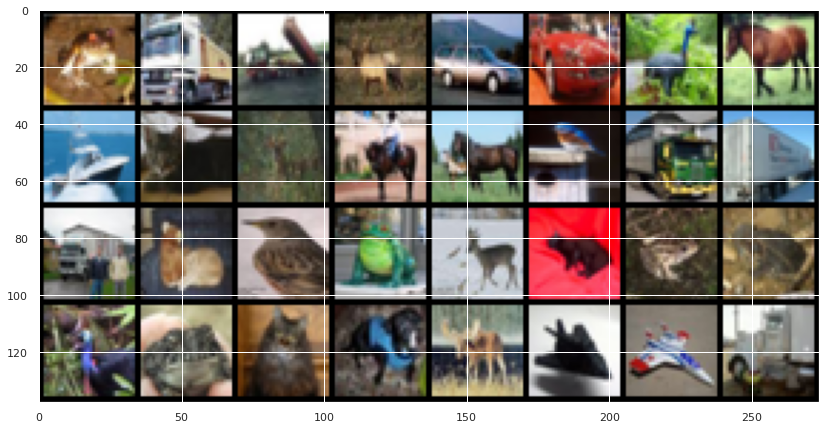

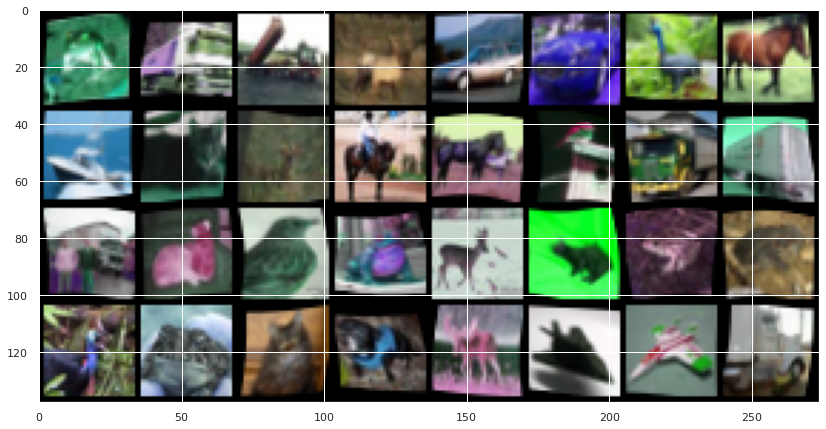

In [26]:
model.show_batch(win_size=(14, 14))

### Trainining

In [57]:
# Initialize a trainer
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20),
               StochasticWeightAveraging(swa_lrs=1e-2)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=50,
)

# Train the model ⚡
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | model          | ResNet           | 11.2 M
1 | preprocess     | Preprocess       | 0     
2 | transform      | DataAugmentation | 0     
3 | train_accuracy | Accuracy         | 0     
4 | val_accuracy   | Accuracy         | 0     
5 | train_cm       | ConfusionMatrix  | 0     
6 | valid_cm       | ConfusionMatrix  | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Files already downloaded and verified
Files already downloaded and verified


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Swapping scheduler `CosineAnnealingLR` for `SWALR`


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [63]:
class ImageFlipAugment(nn.Module):
    """Module to perform data augmentation using Kornia on torch tensors."""

    def __init__(self) -> None:
        super().__init__()

        self.transforms = nn.Sequential(
            RandomHorizontalFlip(p=0.99),
        )
    @torch.no_grad()  # disable gradients for effiency
    def forward(self, x: Tensor) -> Tensor:
        return self.transforms(x)  # BxCxHxW

In [64]:
flip = ImageFlipAugment()

Files already downloaded and verified


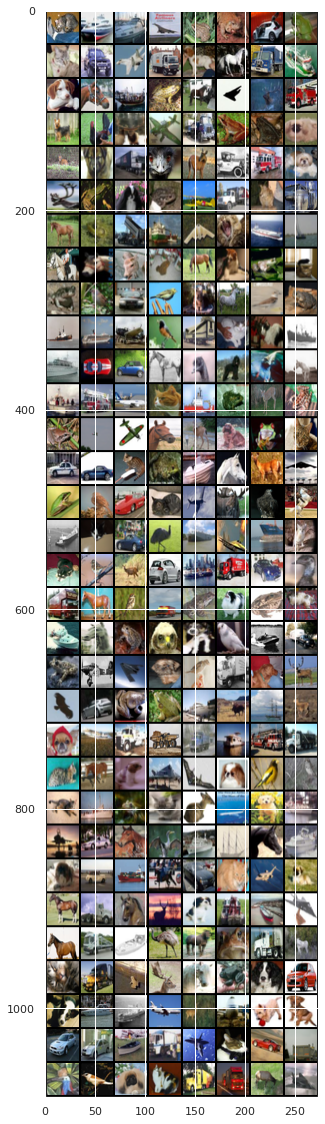

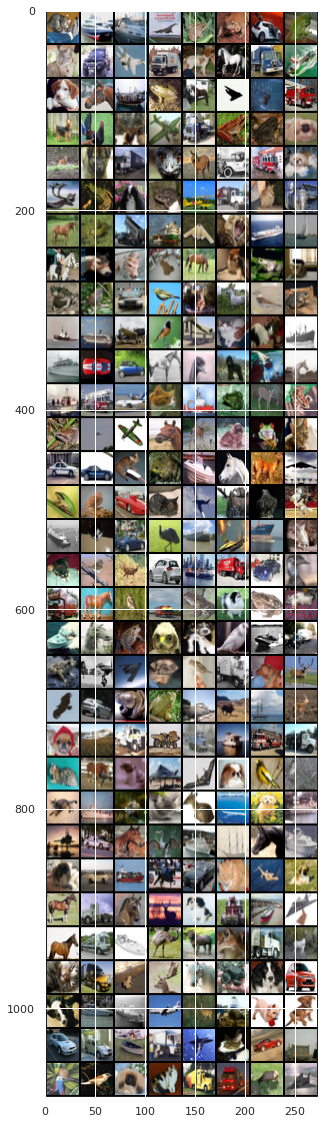

In [67]:
win_size=(20, 20)
def _to_vis(data):
    return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

# get a batch from the training set: try with `val_datlaoader` :)
imgs, labels = next(iter(model.val_dataloader()))
imgs_aug = flip(imgs)  # apply transforms
# use matplotlib to visualize
plt.figure(figsize=win_size)
plt.imshow(_to_vis(imgs))
plt.figure(figsize=win_size)
plt.imshow(_to_vis(imgs_aug))

In [68]:
del imgs_aug, imgs, labels

In [36]:
torch.save(model.model, 'cifar10Resnet18.pt')

## Test time augmentation uncertain fusion

In [150]:
class EvidentialUncertainFusionTTA(LightningModule):
    def __init__(self):
        super().__init__()
        # not the best model: expereiment yourself
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)
        self.preprocess = Preprocess()  # per sample transforms
        self.transform = DataAugmentation()  # per batch augmentation_kornia
        self.flip = RandomHorizontalFlip(p=1.0)#testtime augmentation
        self.train_accuracy = torchmetrics.Accuracy()
        self.val_accuracy = torchmetrics.Accuracy()
        self.val_flip_accuracy = torchmetrics.Accuracy()
        self.ds_fusion_accuracy = torchmetrics.Accuracy()
        self.bayes_fusion_accuracy = torchmetrics.Accuracy()
        self.dampster_fusion_accuracy = torchmetrics.Accuracy()
        self.sum_fusion_accuracy = torchmetrics.Accuracy()
        self.mean_fusion_accuracy = torchmetrics.Accuracy()
        
        
        self.n_classes = 10
        
        self.train_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes, normalize='true')
        self.valid_cm = torchmetrics.ConfusionMatrix(num_classes=self.n_classes)
        
        self.DS_combine = uncertain_fusion.DempsterSchaferCombine(self.n_classes)
        self.mean_combine = uncertain_fusion.MeanUncertainty(self.n_classes)
        self.sum_combine = uncertain_fusion.SumUncertainty(self.n_classes)
        
        if os.path.isfile('cifar_train_cm.npy'): 
            cm = np.load('cifar_train_cm.npy')
            self.bayesian = uncertain_fusion.EffectiveProbability(confusion_matrix = cm)
            #self.dampster = uncertain_fusion.EffectiveProbability(confusion_matrix = cm, fusion_type='dampster')
        else:
            self.bayesian = None
            
        self.metric_data = []
        
        self.fusion_methods = [self.DS_combine, self.bayesian, self.mean_combine, self.sum_combine]
        self.fusion_names = ['2 DS combine', '3 bayesian', '4 mean', '5 sum']
        self.fusion_accuracy = [self.ds_fusion_accuracy, 
                                self.bayes_fusion_accuracy,
                                self.mean_fusion_accuracy,
                                self.sum_fusion_accuracy]
            
    def forward(self, x):
        return self.model(x)

    def compute_loss(self, y_hat, y):
        y = F.one_hot(y, self.n_classes)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = evidence_loss.edl_mse_loss(y_hat, y, self.current_epoch, self.n_classes, 5)
   
        #return F.cross_entropy(y_hat, y)
        return loss

    def show_batch(self, win_size=(10, 10)):
        def _to_vis(data):
            return tensor_to_image(torchvision.utils.make_grid(data, nrow=8))

        # get a batch from the training set: try with `val_datlaoader` :)
        imgs, labels = next(iter(self.train_dataloader()))
        imgs_aug = self.transform(imgs)  # apply transforms
        # use matplotlib to visualize
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs))
        plt.figure(figsize=win_size)
        plt.imshow(_to_vis(imgs_aug))

    def on_after_batch_transfer(self, batch, dataloader_idx):
        x, y = batch
        if self.trainer.training:
            x = self.transform(x)  # => we perform GPU/Batched data augmentation
        return x, y

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.train_accuracy.update(y_hat, y)
        #self.log("train_loss", loss, prog_bar=False)
        self.log("train_acc", self.train_accuracy, prog_bar=False)
        self.logger.experiment.add_scalars('loss', {'train': loss}, self.global_step)
        #self.logger.experiment.add_scalars('accuracy', {'train': self.train_accuracy}, self.global_step) 
        
        y_hat = y_hat.argmax(dim=1, keepdim=True)
        self.train_cm(y_hat, y)
        return loss
    
    def training_epoch_end(self, outputs):
        np.save('cifar_train_cm.npy', self.train_cm.compute().cpu().numpy())
        self.train_cm.reset()
    
    def log_special(self, name, t):
        mean=torch.mean(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median=torch.median(torch.max(t, dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        mean_prob=torch.mean(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        median_prob=torch.median(torch.max(t/torch.sum(t, dim=1, keepdim=True), 
                                            dim=1, keepdim=True).values).cpu().numpy().round(decimals=2)
        uncertain=torch.mean(self.n_classes/torch.sum(t, dim=1, keepdim=True)).cpu().numpy().round(decimals=2)
        
        return [name, mean, median, mean_prob, median_prob, uncertain]
        

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.compute_loss(y_hat, y)
        self.val_accuracy.update(y_hat, y)
        #self.log("valid_loss", loss, prog_bar=False)
        #self.logger.experiment.add_scalars('loss', {'valid': loss}, self.global_step) 
        #self.logger.experiment.add_scalars('accuracy', {'valid': self.val_accuracy}, self.global_step) 
        self.log("valid_acc", self.val_accuracy, prog_bar=True)
                
        #Uncertain fusion
        xflip = self.flip(x)
        yflip_hat = F.relu(self(xflip)) + 1
        self.val_flip_accuracy.update(yflip_hat, y)
        self.log("valid_flip_acc", self.val_flip_accuracy, prog_bar=True)
        
        y_hat = F.relu(y_hat) + 1
        
        #flipped image details
        self.metric_data.append(self.log_special("1 Frame flip ", yflip_hat))
        y_max = yflip_hat.argmax(dim=1)
        flip_correct_flags = (y_max == y)
        self.metric_data.append(self.log_special("Correct flip ", yflip_hat[flip_correct_flags]))
        self.metric_data.append(self.log_special("InCorrect flip ", yflip_hat[~flip_correct_flags]))
        
        #First frame
        self.metric_data.append(self.log_special("0 Frame ", y_hat))        
        y_max = y_hat.argmax(dim=1)            
        correct_flags = (y_max == y)
        self.metric_data.append(self.log_special("Correct 0", y_hat[correct_flags]))
        self.metric_data.append(self.log_special("InCorrect 0 ", y_hat[~correct_flags]))
        
        
        
        #for fusion, name, accuracy in zip([self.DS_combine, self.bayesian, self.dampster], 
        #                                  ['2 dampster', '3 bayesian', '4 destructive'], 
        #                                  [ self.ds_fusion_accuracy, self.bayes_fusion_accuracy, 
        #                                   self.dampster_fusion_accuracy]):
        for fusion, name, accuracy in zip(self.fusion_methods, 
                                          self.fusion_names, 
                                          self.fusion_accuracy):
         
            fusion_out = fusion(y_hat, yflip_hat)
            fusion_out = fusion_out.to(self.device)
            accuracy.update(fusion_out, y)
            self.log(name+"_fusion", accuracy, prog_bar=True)
            
            self.metric_data.append(self.log_special(name+" Fusion ", fusion_out))
                  
            y_max = fusion_out.argmax(dim=1)
            fused_correct_flags = (y_max == y)
            self.metric_data.append(self.log_special("Correct Fusion "+name, fusion_out[fused_correct_flags]))
            self.metric_data.append(self.log_special("InCorrect Fusion "+name, fusion_out[~fused_correct_flags]))
            
            #finding images which were wrong in first prediction and correct in fusion
            c = fused_correct_flags & ~correct_flags & ~flip_correct_flags
            
            
            self.plot_changes(x[c], y[c], y_hat[c], yflip_hat[c], fusion_out[c], name)
            
        self.valid_cm(y_max, y)
        
        return loss
    
    def plot_changes(self, x, y, frame0, frame1, fused, fusion_name):
        if (len(x)==0):
            return
        #fig = plt.figure(figsize=(5, 5))
        fig, ax = plt.subplots(figsize=(8,8))

        title = ['Input Image', 'True Mask', 'Predicted Mask']
        
        frame0 = frame0/torch.sum(frame0, dim=1, keepdim=True)
        frame1 = frame1/torch.sum(frame1, dim=1, keepdim=True)
        fused = fused/torch.sum(fused, dim=1, keepdim=True)
        
        both = torch.concat((frame0,frame1,fused), dim=1)
        print ("Total images",len(x))
        
        

        for i, (img, label, f) in enumerate(zip(x, y, both)):
            plt.subplot(len(x),2, (i*2)+1)
            plt.title(label.cpu().numpy())
            plt.imshow(tensor_to_image(img))
            plt.axis('off')
            f=f.reshape(3,self.n_classes)
            plt.subplot(len(x),2, (i*2)+2)
            plt.title(fusion_name)
            plt.imshow(tensor_to_image(f))
            plt.axis('off')
            
        plt.show()    
        # log figure
        self.logger.experiment.add_figure('sample images', fig, global_step=self.global_step)
    
        
    def validation_epoch_end(self, outputs):
        # turn confusion matrix into a figure (Tensor cannot be logged as a scalar)
        fig, ax = plt.subplots(figsize=(8,8))
        #plt.imshow(self.valid_cm.compute().cpu().numpy())
        disp = ConfusionMatrixDisplay(self.valid_cm.compute().cpu().numpy())
        disp.plot(ax=ax)
        
        # log figure
        self.logger.experiment.add_figure('valid_epoch_confmat', fig, global_step=self.global_step)
    
        self.valid_cm.reset()
        metrics = pd.DataFrame(self.metric_data, columns=['name', 
                                                          'mean', 
                                                          'median', 
                                                          'mean_prob', 
                                                          'median_prob', 
                                                          'uncertain'])
        print (metrics.groupby('name', as_index=False).mean().round(2))
        

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, 
        #                                                steps_per_epoch=len(self.train_dataloader()), 
        #                                                epochs=self.trainer.max_epochs)
        return [optimizer]#, [scheduler]

    def prepare_data(self):
        CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)

    def train_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=True, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=256, shuffle=True, num_workers=int(16/2))
        return loader

    def val_dataloader(self):
        dataset = CIFAR10(os.getcwd(), train=False, download=True, transform=self.preprocess)
        loader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=int(16/2))
        return loader

In [151]:
model = EvidentialUncertainFusionTTA()
model.model = torch.load('cifar10Resnet18.pt')

Initialized fusion type :  bayes


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Files already downloaded and verified


Validating: 0it [00:00, ?it/s]

Total images 1


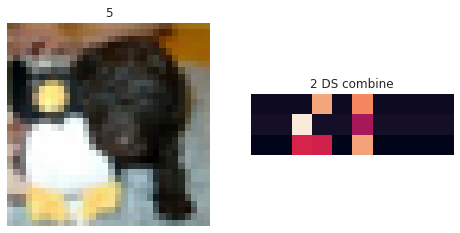

Total images 1


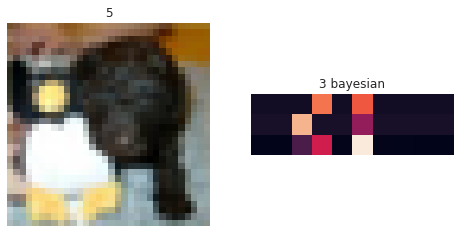

Total images 1


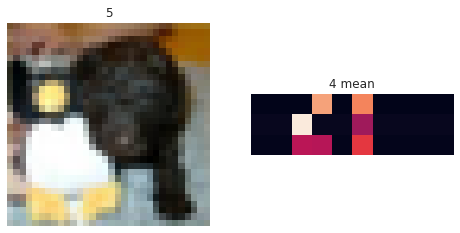

Total images 1


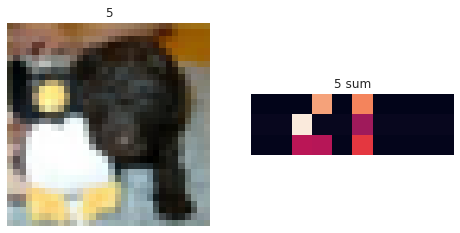

Total images 1


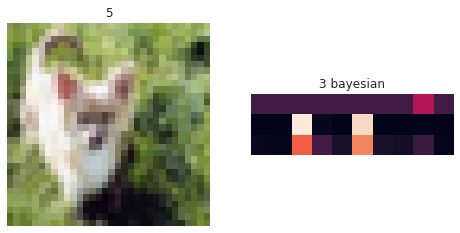

                             name    mean  median  mean_prob  median_prob  \
0                        0 Frame    49.31   49.16       0.76         0.84   
1                   1 Frame flip    49.94   50.28       0.77         0.85   
2            2 DS combine Fusion   396.00  300.47       0.87         0.97   
3              3 bayesian Fusion     0.90    0.99       0.90         0.99   
4                  4 mean Fusion    48.77   48.09       0.75         0.84   
5                   5 sum Fusion    97.53   96.18       0.75         0.84   
6                       Correct 0   57.43   59.59       0.81         0.87   
7     Correct Fusion 2 DS combine  473.99  427.06       0.92         0.98   
8       Correct Fusion 3 bayesian    0.94    0.99       0.94         0.99   
9           Correct Fusion 4 mean   56.04   58.01       0.81         0.86   
10           Correct Fusion 5 sum  112.08  116.02       0.81         0.86   
11                  Correct flip    58.04   60.80       0.82         0.87   

[{'valid_acc': 0.7806000113487244,
  'valid_flip_acc': 0.7854999899864197,
  '2 DS combine_fusion': 0.8037999868392944,
  '3 bayesian_fusion': 0.7968999743461609,
  '4 mean_fusion': 0.804099977016449,
  '5 sum_fusion': 0.804099977016449}]

In [152]:
# Initialize a trainer
trainer = Trainer(
    callbacks=[TQDMProgressBar(refresh_rate=20),
               StochasticWeightAveraging(swa_lrs=1e-2)],
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    max_epochs=1,
)

#trainer.fit(model)
# Train the model ⚡
trainer.validate(model)

In [81]:
torch.save(model.model, 'cifar10Resnet18.pt')

In [18]:
x = torch.tensor(0.55555)
x.cpu().numpy().round()

1.0

In [ ]:
### Results Comparison Correct/Incorrect predictions 

                              name    mean  median  mean_prob  median_prob  \
0                         0 Frame    21.91    4.94       0.43         0.33   
1                    1 Frame flip    21.91    5.40       0.44         0.35   
2               2 dampster Fusion   147.38   18.13       0.56         0.63   
3               3 bayesian Fusion     0.54    0.53       0.54         0.53   
4            4 destructive Fusion     0.48    0.43       0.48         0.43   
5                        Correct 0   40.33   32.68       0.68         0.78   
6        Correct Fusion 2 dampster  251.82   78.08       0.78         0.88   
7        Correct Fusion 3 bayesian    0.74    0.89       0.74         0.89   
8     Correct Fusion 4 destructive    0.66    0.73       0.66         0.73   
9                    Correct flip    40.10   32.41       0.69         0.78   
10                    InCorrect 0     5.16    1.00       0.20         0.10   
11     InCorrect Fusion 2 dampster   18.59    1.00       0.28         0.10   
12     InCorrect Fusion 3 bayesian    0.27    0.10       0.27         0.10   
13  InCorrect Fusion 4 destructive    0.25    0.13       0.25         0.13   
14                 InCorrect flip     5.14    1.00       0.21         0.10   

    uncertain  
0        0.63  
1        0.63  
2        0.48  
3       10.00  
4       10.00  
5        0.35  
6        0.23  
7       10.00  
8       10.00  
9        0.35  
10       0.89  
11       0.79  
12      10.00  
13      10.00  
14       0.88  
--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'2 dampster_fusion': 0.5519999861717224,
 '3 bayesian_fusion': 0.5683000087738037,
 '4 destructive_fusion': 0.5644000172615051,
 'valid_acc': 0.6251000165939331}

In [101]:
x = torch.rand(2, 5)
f = x>0.5
f & f

tensor([[ True,  True,  True,  True,  True],
        [ True,  True, False, False, False]])

## Entropy Dirichlet and Multinomial


$${\displaystyle H(X)=\log \mathrm {B} ({\boldsymbol {\alpha }})} + ( \alpha_0 − K ) ψ ( \alpha_0 ) − \sum{j=1}{} K ( \alpha_j − 1 ) ψ ( \alpha_j ) $$
with α 0 {\displaystyle \alpha _{0}} \alpha _{0} defined as for variance, above; and ψ {\displaystyle \psi } \psi is the digamma function

In [160]:
x = torch.tensor([[1,1],[10,10],[100, 100],[10,1], [100,5]])
d = torch.distributions.dirichlet.Dirichlet(x)
d.entropy()

tensor([ 0.0000, -0.7983, -1.9259, -1.4026, -2.5202])

In [168]:
x = torch.tensor([[1.,1.,1.],[10.,10., 10.],[100., 100., 100.],[10.,1., 1.], [100.,5., 5.]])
d = torch.distributions.dirichlet.Dirichlet(x)
print (d.entropy())
s = d.sample()
print (s)

tensor([-0.6931, -2.2690, -4.5194, -2.9823, -5.1327])
tensor([[0.7059, 0.2789, 0.0152],
        [0.4967, 0.2975, 0.2058],
        [0.3674, 0.3395, 0.2931],
        [0.9004, 0.0499, 0.0498],
        [0.9164, 0.0543, 0.0293]])


In [169]:
x = torch.tensor([[0.1,0.1,0.8],[0.3,0.4, 0.3]])
d = torch.distributions.categorical.Categorical(s)
d.entropy()


tensor([0.6655, 1.0336, 1.0943, 0.3934, 0.3417])

## Catalyst

In [3]:
import os
from pathlib import Path
from datetime import datetime

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import CIFAR10
import torchvision.models as models
import torchvision.transforms as transforms

from catalyst import dl, metrics, utils
#from catalyst.data.transforms import ToTensor
from catalyst.contrib.data.transforms import ImageToTensor

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /home/deebuls/Documents/phd/blender-dataset/SemanticTemporalFusion/semantic_segmentation_notebooks/cifar-10-python.tar.gz to /home/deebuls/Documents/phd/blender-dataset/SemanticTemporalFusion/semantic_segmentation_notebooks


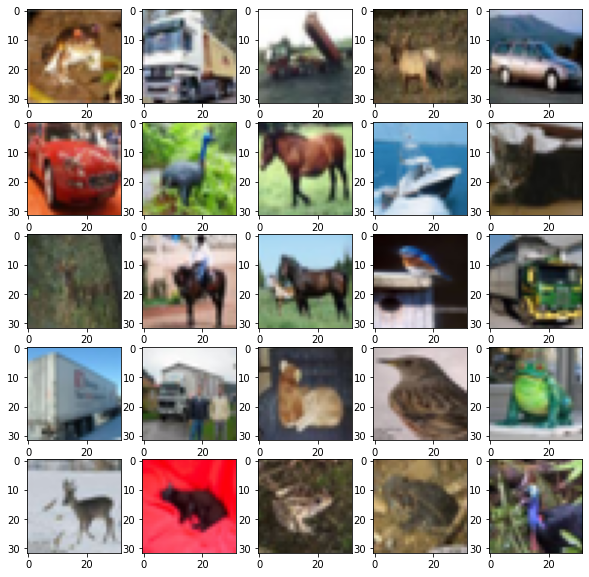

In [9]:
import matplotlib.pyplot as plt
import os


cifar_dataset = CIFAR10(os.getcwd(), train=True, download=True)

_, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(25):
    ax[i // 5, i % 5].imshow(cifar_dataset[i][0], cmap="gray")

In [10]:
cifar_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # ImageNet normalizer
        transforms.Normalize(
            (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
        ),
    ]
)

loaders = {
    "train": DataLoader(
        CIFAR10(
            os.getcwd(), train=True, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
    "valid": DataLoader(
        CIFAR10(
            os.getcwd(), train=False, download=True, transform=cifar_transform
        ),
        batch_size=256,
    ),
}

Files already downloaded and verified
Files already downloaded and verified


In [11]:
class CIFARrunner(dl.Runner):

    def predict_batch(self, batch):
        # model inference step
        return self.model(batch[0].to(self.device))

    def handle_batch(self, batch):
        # model train/valid step
        x, y = batch
        y_pred = self.model(x)

        self.batch = {"features": x, "logits": y_pred, "targets": y}

In [18]:
from catalyst.contrib.optimizers.lookahead import Lookahead

net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)
optimizer = Lookahead(torch.optim.Adam(net.parameters(), lr=1e-3))
criterion = nn.CrossEntropyLoss()

runner = CIFARrunner()
# model training


# model training
runner.train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir="./lightning_logs/",
    num_epochs=5,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.CheckpointCallback(
            "./lightning_logs/", loader_key="valid", metric_key="loss", minimize=True, topk=3
        ),
    ]
)

# model evaluation
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5))],
)

1/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (1/5) accuracy01: 0.5017400000572204 | accuracy01/std: 0.08293154534095401 | accuracy03: 0.8102200000381465 | accuracy03/std: 0.07484394939051661 | f1/_macro: 0.49918245082013274 | f1/_micro: 0.5017350000498261 | f1/_weighted: 0.4991824508201327 | loss: 1.3905428386688228 | loss/mean: 1.3905428386688228 | loss/std: 0.23622897561848585 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.4978221032211426 | precision/_micro: 0.5017400000000001 | precision/_weighted: 0.4978221032211426 | recall/_macro: 0.50174 | recall/_micro: 0.5017400000000001 | recall/_weighted: 0.50174


1/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (1/5) accuracy01: 0.609 | accuracy01/std: 0.02983593082638494 | accuracy03: 0.8848 | accuracy03/std: 0.019845481458342876 | f1/_macro: 0.6043886543222461 | f1/_micro: 0.6089950000410504 | f1/_weighted: 0.6043886543222461 | loss: 1.1034607790946962 | loss/mean: 1.1034607790946962 | loss/std: 0.06767494191190761 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6071794351191432 | precision/_micro: 0.609 | precision/_weighted: 0.6071794351191432 | recall/_macro: 0.6089999999999999 | recall/_micro: 0.609 | recall/_weighted: 0.609
* Epoch (1/5) 


2/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (2/5) accuracy01: 0.6488000000190733 | accuracy01/std: 0.038443491826434105 | accuracy03: 0.9044400000190735 | accuracy03/std: 0.02171438650010456 | f1/_macro: 0.647602983304525 | f1/_micro: 0.6487950000385324 | f1/_weighted: 0.647602983304525 | loss: 0.9840769799995432 | loss/mean: 0.9840769799995432 | loss/std: 0.10094099848450644 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6469209438689703 | precision/_micro: 0.6488 | precision/_weighted: 0.6469209438689704 | recall/_macro: 0.6487999999999999 | recall/_micro: 0.6488 | recall/_weighted: 0.6488000000000002


2/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (2/5) accuracy01: 0.6432999999999999 | accuracy01/std: 0.029888531787848723 | accuracy03: 0.8965 | accuracy03/std: 0.01771872654360443 | f1/_macro: 0.6423931785130408 | f1/_micro: 0.6432950000388618 | f1/_weighted: 0.6423931785130409 | loss: 1.0227148301124573 | loss/mean: 1.0227148301124573 | loss/std: 0.07645889217552654 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6621724958927062 | precision/_micro: 0.6433 | precision/_weighted: 0.6621724958927061 | recall/_macro: 0.6433 | recall/_micro: 0.6433 | recall/_weighted: 0.6433
* Epoch (2/5) 


3/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (3/5) accuracy01: 0.7312599999809264 | accuracy01/std: 0.03290881802565985 | accuracy03: 0.938260000019074 | accuracy03/std: 0.017134308377312064 | f1/_macro: 0.7304177470851685 | f1/_micro: 0.7312550000341873 | f1/_weighted: 0.7304177470851685 | loss: 0.7613013719177247 | loss/mean: 0.7613013719177247 | loss/std: 0.08547420330254381 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.7298466337729745 | precision/_micro: 0.73126 | precision/_weighted: 0.7298466337729747 | recall/_macro: 0.73126 | recall/_micro: 0.73126 | recall/_weighted: 0.73126


3/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (3/5) accuracy01: 0.6384000000000001 | accuracy01/std: 0.026505499507657192 | accuracy03: 0.8936000000000001 | accuracy03/std: 0.016374654589678923 | f1/_macro: 0.6382144279224523 | f1/_micro: 0.6383950000391602 | f1/_weighted: 0.6382144279224523 | loss: 1.0838972558975217 | loss/mean: 1.0838972558975217 | loss/std: 0.0882839124324545 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6741218927153942 | precision/_micro: 0.6384000000000001 | precision/_weighted: 0.6741218927153942 | recall/_macro: 0.6384000000000001 | recall/_micro: 0.6384000000000001 | recall/_weighted: 0.6384000000000001
* Epoch (3/5) 


4/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (4/5) accuracy01: 0.7915199999999998 | accuracy01/std: 0.032320676315980026 | accuracy03: 0.95996 | accuracy03/std: 0.013587295252987146 | f1/_macro: 0.7911129090677979 | f1/_micro: 0.7915150000315845 | f1/_weighted: 0.7911129090677979 | loss: 0.5916155479717257 | loss/mean: 0.5916155479717257 | loss/std: 0.07666888447710701 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.7908720308143318 | precision/_micro: 0.79152 | precision/_weighted: 0.7908720308143319 | recall/_macro: 0.79152 | recall/_micro: 0.79152 | recall/_weighted: 0.7915200000000001


4/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (4/5) accuracy01: 0.6114 | accuracy01/std: 0.031904171555084494 | accuracy03: 0.8827999999999998 | accuracy03/std: 0.0182681313347109 | f1/_macro: 0.6176205069505223 | f1/_micro: 0.6113950000408893 | f1/_weighted: 0.6176205069505223 | loss: 1.255984173965454 | loss/mean: 1.255984173965454 | loss/std: 0.10909324225774668 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6463777474064301 | precision/_micro: 0.6113999999999999 | precision/_weighted: 0.6463777474064301 | recall/_macro: 0.6113999999999999 | recall/_micro: 0.6113999999999999 | recall/_weighted: 0.6114
* Epoch (4/5) 


5/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

train (5/5) accuracy01: 0.8349400000190729 | accuracy01/std: 0.031428200442774085 | accuracy03: 0.97354 | accuracy03/std: 0.011690509328518037 | f1/_macro: 0.834757550223306 | f1/_micro: 0.8349350000299421 | f1/_weighted: 0.8347575502233061 | loss: 0.4695917163705822 | loss/mean: 0.4695917163705822 | loss/std: 0.08079926526954909 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.8346601137394742 | precision/_micro: 0.83494 | precision/_weighted: 0.8346601137394742 | recall/_macro: 0.8349399999999999 | recall/_micro: 0.83494 | recall/_weighted: 0.83494


5/5 * Epoch (valid):   0%|          | 0/40 [00:00<?, ?it/s]

valid (5/5) accuracy01: 0.6121000000000002 | accuracy01/std: 0.030524253438942644 | accuracy03: 0.8677999999999999 | accuracy03/std: 0.02012066373435308 | f1/_macro: 0.6189221830426639 | f1/_micro: 0.6120950000408426 | f1/_weighted: 0.618922183042664 | loss: 1.4291132986068724 | loss/mean: 1.4291132986068724 | loss/std: 0.14641300868350698 | lr: 0.001 | momentum: 0.9 | precision/_macro: 0.6592737389964715 | precision/_micro: 0.6121 | precision/_weighted: 0.6592737389964715 | recall/_macro: 0.6121 | recall/_micro: 0.6121 | recall/_weighted: 0.6121
* Epoch (5/5) 
Top models:
./lightning_logs//model.0002.pth	1.0227
./lightning_logs//model.0003.pth	1.0839
./lightning_logs//model.0001.pth	1.1035
valid (1/1) accuracy01: 0.6121000000000002 | accuracy01/std: 0.030524253438942644 | accuracy03: 0.8677999999999999 | accuracy03/std: 0.02012066373435308 | accuracy05: 0.9555999999999999 | accuracy05/std: 0.012645394046808502
* Epoch (1/1) 


## Evidential Catalyst

In [ ]:

class EvidentialCIFARRunner(dl.Runner):
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = {
            key: metrics.AdditiveMetric(compute_on_call=False)
            for key in ["loss", "mae"]
        }

    def handle_batch(self, batch):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `train()`.
        x, y = batch

        y_pred = self.model(x) # Forward pass

        # Compute the loss value
        loss = F.mse_loss(y_pred, y)
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask, self.epoch, self.n_classes, 10)
   

        # Update metrics (includes the metric that tracks the loss)
        self.batch_metrics.update({"loss": loss, "mae": F.l1_loss(y_pred, y)})
        for key in ["loss", "mae"]:
            self.meters[key].update(self.batch_metrics[key].item(), self.batch_size)

        if self.is_train_loader:
            # Compute gradients
            loss.backward()
            # Update weights
            # (the optimizer is stored in `self.state`)
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def on_loader_end(self, runner):
        for key in ["loss", "mae"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)

In [20]:
from catalyst.contrib.optimizers.lookahead import Lookahead
import evidence_loss

net = models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, 10)
optimizer = Lookahead(torch.optim.Adam(net.parameters(), lr=1e-3))
criterion = evidence_loss.edl_mse_loss

runner = CIFARrunner()
# model training


# model training
runner.train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    logdir="./lightning_logs/",
    num_epochs=5,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3)),
        dl.PrecisionRecallF1SupportCallback(
            input_key="logits", target_key="targets", num_classes=10
        ),
        dl.CriterionCallback(input_key="logits", target_key="targets", metric_key="loss"),
        dl.BackwardCallback(metric_key="loss"),
        dl.OptimizerCallback(metric_key="loss"),
        dl.CheckpointCallback(
            "./lightning_logs/", loader_key="valid", metric_key="loss", minimize=True, topk=3
        ),
    ]
)

# model evaluation
metrics = runner.evaluate_loader(
    loader=loaders["valid"],
    callbacks=[dl.AccuracyCallback(input_key="logits", target_key="targets", topk=(1, 3, 5))],
)

1/5 * Epoch (train):   0%|          | 0/196 [00:00<?, ?it/s]

TypeError: edl_mse_loss() missing 3 required positional arguments: 'epoch_num', 'num_classes', and 'annealing_step'